In [5]:
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels joblib tqdm


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
from tqdm.auto import tqdm

In [7]:
!pip install opendatasets

In [8]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/gratefuldata/intraday-stock-data-1-min-sp-500-200821/data")

Skipping, found downloaded files in "./intraday-stock-data-1-min-sp-500-200821" (use force=True to force download)


In [9]:
df = pd.read_csv('/content/intraday-stock-data-1-min-sp-500-200821/1_min_SPY_2008-2021.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
y = df['close'].astype(float)

In [10]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [11]:
# For LSTM
def reshape_for_lstm(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

In [12]:
# LSTM model
def build_lstm_model(input_shape):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [16]:
# ------------ Per-Fold Evaluation Function ------------
def process_fold(fold, train_idx, test_idx, n_steps=20, max_train_len=5000, enable_lstm=False):
    result = {'fold': fold}

    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Reduce training data size for speed/memory
    if len(y_train) > max_train_len:
        y_train = y_train[-max_train_len:]

    # ARIMA
    try:
        arima_model = ARIMA(y_train, order=(5, 1, 0)).fit()
        arima_forecast = arima_model.forecast(steps=len(y_test))
        result['ARIMA'] = np.sqrt(mean_squared_error(y_test, arima_forecast))
    except Exception:
        result['ARIMA'] = None

    # SARIMA
    try:
        sarima_model = SARIMAX(y_train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12)).fit(disp=False)
        sarima_forecast = sarima_model.forecast(steps=len(y_test))
        result['SARIMA'] = np.sqrt(mean_squared_error(y_test, sarima_forecast))
    except Exception:
        result['SARIMA'] = None

    # LSTM (optional)
    if enable_lstm:
        try:
            series = y_train.to_numpy()
            X_train_lstm, y_train_lstm = reshape_for_lstm(series, n_steps)
            X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))

            lstm_model = build_lstm_model((n_steps, 1))
            lstm_model.fit(X_train_lstm, y_train_lstm, epochs=2, batch_size=32, verbose=0)

            test_series = np.concatenate([series[-n_steps:], y_test.to_numpy()])
            X_test_lstm, _ = reshape_for_lstm(test_series, n_steps)
            X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

            lstm_forecast = lstm_model.predict(X_test_lstm, verbose=0)
            result['LSTM'] = np.sqrt(mean_squared_error(y_test[:len(lstm_forecast)], lstm_forecast.flatten()))
        except Exception:
            result['LSTM'] = None

    return result


In [17]:
# ------------ Run Cross-Validation ------------
ENABLE_LSTM = False  # Set to True if you want to include LSTM
MAX_PARALLEL_JOBS = 2  # Reduce if memory is low

results = Parallel(n_jobs=MAX_PARALLEL_JOBS, backend="loky")(
    delayed(process_fold)(fold, train_idx, test_idx, enable_lstm=ENABLE_LSTM)
    for fold, (train_idx, test_idx) in tqdm(enumerate(tscv.split(y), 1), total=n_splits)
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
results_df = pd.DataFrame(results)
print("\nCross-Validation RMSE Results:\n", results_df)



Cross-Validation RMSE Results:
    fold       ARIMA       SARIMA
0     1   83.861936    88.502004
1     2  110.294492  8115.844877
2     3   89.896523  3849.859988
3     4   84.184336   917.233617
4     5  106.917978  1486.553711


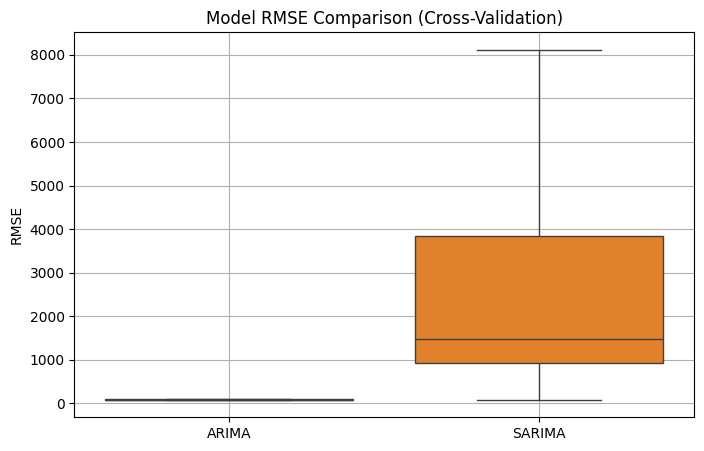

In [20]:
# ------------ Plot Comparison ------------
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=results_df[['ARIMA', 'SARIMA', 'LSTM']] if ENABLE_LSTM else results_df[['ARIMA', 'SARIMA']])
plt.title("Model RMSE Comparison (Cross-Validation)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

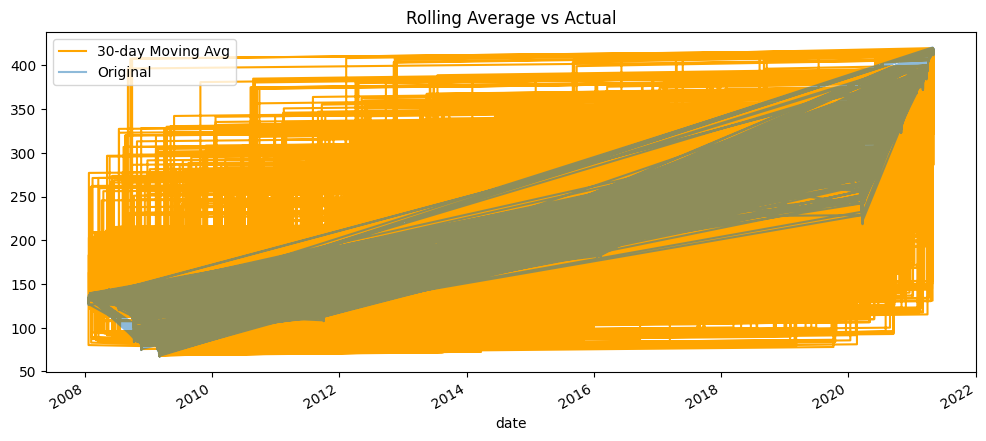

In [21]:
# Rolling average plot
plt.figure(figsize=(12,5))
y.rolling(window=30).mean().plot(label='30-day Moving Avg', color='orange')
y.plot(alpha=0.5, label='Original')
plt.legend()
plt.title("Rolling Average vs Actual")
plt.show()